# Naive Bayes

## Spam / Ham message classification

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import joblib
import matplotlib.pyplot as plt

### Loading Dataset

In [2]:
data = pd.read_csv('messages.csv')

In [3]:
data.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [4]:
data.describe()

,type,text
count,5559,5559
unique,2,5156
top,ham,"Sorry, I'll call later"
freq,4812,30


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5559 non-null   object
 1   text    5559 non-null   object
dtypes: object(2)
memory usage: 43.5+ KB


### Handle & Processing Null Values

In [6]:
data.isnull().any()

type    False
text    False
dtype: bool

### Building Model

#### Separating Span & Ham messages

In [7]:
spamMessages = data[data.type == 'spam']
hamMessages = data[data.type == 'ham']

In [8]:
spamMessages.describe()

,type,text
count,747,747
unique,1,653
top,spam,Please call our customer service representativ...
freq,747,4


In [9]:
hamMessages.describe()

,type,text
count,4812,4812
unique,1,4503
top,ham,"Sorry, I'll call later"
freq,4812,30


#### Theory

In [10]:
'''
Naive Bayes Theorem:
for sentence : you win 100$

if probability(spam / sentence) > probability(ham / sentence): sentence is spam
if probability(spam / sentence) < probability(ham / sentence): sentence is ham
if probability(spam / sentence) == probability(ham / sentence): no classification


> probability(spam / sentence) = (probability(sentence / spam) * probability(spam)) / probability(sentence)
> probability(ham / sentence) = (probability(sentence / ham) * probability(ham)) / probability(sentence)

# Since we are comparing the probabilities we can ignore the denomenators
> probability(spam / sentence) = (probability(sentence / spam) * probability(spam))
> probability(ham / sentence) = (probability(sentence / ham) * probability(ham))


probability(spam) = count of spam messages in dataset / total sample counts in dataset
probability(ham) = count of ham messages in dataset / total sample counts in dataset


# to determine this tokenize the sentence to words and take probability of each word
probability(sentence / spam) = probability(you / spam) * probability(win / spam) * probability(100$ / spam)

probability(you / spam) = count of you in spam / total words in spam

# to make this process efficient we can remote the stopwords from sentence
'''
pass

#### Calculate spam and ham probability

In [11]:
spamProbability = len(spamMessages.index) / len(data.index)
hamProbability = len(hamMessages.index) / len(data.index)

#### Calculate Word Frequency

In [12]:
def wordFrequencyGenerator(textList):
    result = {}
    for statement in textList:
        # tokenize the statement
        wordList = statement.split()
        
        # check in dictionary
        for word in wordList:
            if word in result.keys():
                # update the frequency
                result[word] = result[word] + 1
            else:
                # update the dict
                result[word] = 1
    
    return result

In [13]:
spamWordFrequecy = wordFrequencyGenerator(spamMessages.text.values)
hamWordFrequecy = wordFrequencyGenerator(hamMessages.text.values)

In [14]:
import copy
def filteringStopwords(wordDictionary):
    englishStopwords = stopwords.words('english')
    temp = copy.copy(wordDictionary)
    for key in wordDictionary.keys():
        if key in englishStopwords:
            del temp[key]
    
    wordDictionary = temp
    return wordDictionary

In [15]:
spamWordFrequecy = filteringStopwords(spamWordFrequecy)
hamWordFrequecy = filteringStopwords(hamWordFrequecy)

In [16]:
def frequecyToProbability(dic):
    totalWords = len(dic.keys())
    temp = copy.copy(dic)
    for key in temp.keys():
        # probability of word = frequency of word / total words in class or group
        temp[key] = temp[key] / totalWords
    return temp

In [17]:
spamWordProbability = frequecyToProbability(spamWordFrequecy)
hamWordProbability = frequecyToProbability(hamWordFrequecy)

In [18]:
def dicToDataFrame(dic):
    keys = list(dic.keys())
    values = list(dic.values())
    df = pd.DataFrame()
    df['word'] = keys
    df['probability'] = values
    return df

In [19]:
spamWordProbabilityDf = dicToDataFrame(spamWordProbability)
hamWordProbabilityDf = dicToDataFrame(hamWordProbability)

#### Displaying Word Probability

In [20]:
spamWordProbabilityDf.head()

,word,probability
0,complimentary,0.002848
1,4,0.022075
2,STAR,0.000237
3,Ibiza,0.000949
4,Holiday,0.004985


In [21]:
hamWordProbabilityDf.head()

,word,probability
0,Hope,0.003587
1,good,0.008966
2,week.,0.001060
3,Just,0.007255
4,checking,0.000897


### Visualizing Probabilities

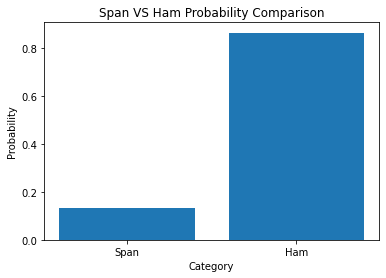

In [22]:
plt.bar(['Span','Ham'], [spamProbability, hamProbability])
plt.xlabel('Category')
plt.ylabel('Probability')
plt.title('Span VS Ham Probability Comparison')
plt.show()

### Calculate Categarization

In [23]:
def listStopwordFiltering(wordList):
    temp = []
    englishStopwords = stopwords.words('english')
    for word in wordList:
        if word not in englishStopwords:
            temp.append(word)
    return temp

def spamFilter(statement):
    wordList = statement.split()
    wordList = listStopwordFiltering(wordList)
    
    # check for spam
    # max
    wordProbabilitySpam = 1
    spamWordsLength = len(list(spamWordProbability.keys()))
    for word in wordList:
        # check in dic for probability
        if word in spamWordProbability.keys():
            wordProbabilitySpam = wordProbabilitySpam * spamWordProbability[word]
        else:
            wordProbabilitySpam = wordProbabilitySpam * (1/spamWordsLength)
    
    spam = wordProbabilitySpam * spamProbability
    
    wordProbabilityHam = 1
    hamWordsLength = len(list(hamWordProbability.keys()))
    for word in wordList:
        # check in dic for probability
        if word in hamWordProbability.keys():
            wordProbabilityHam = wordProbabilityHam * hamWordProbability[word]
        else:
            wordProbabilityHam = wordProbabilityHam * (1/hamWordsLength)
    
    ham = wordProbabilityHam * hamProbability
    
    if spam > ham:
        return 'spam', spam
    elif ham > spam:
        return 'ham', ham
    else:
        return 'no result', 0

#### Check for results

In [24]:
result, prob = spamFilter('Hope you are having a good week')
result, prob

('ham', 8.622567462697388e-08)

In [25]:
result, prob = spamFilter('You win the gift')
result, prob

('spam', 4.6492141718252525e-08)

In [26]:
result, prob = spamFilter('How is your day')
result, prob

('ham', 7.573005035044783e-05)

In [27]:
result, prob = spamFilter('What is your name?')
result, prob

('ham', 5.751503786014113e-07)